##### AttentionUNet with 3 channels

In [1]:
# Update the notebook to incorporate any changes made in the environment
%load_ext autoreload
%autoreload 2

In [2]:
# imports

# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Unet
from monai.networks.nets import UNet

In [3]:
from src.load_XY import load_XY_3chanel


# Dataset import:
data_folder = "./data"

X, y = load_XY_3chanel(data_folder)

#### Preprocessing

In [4]:
import random


# Assuming X and y are your data lists
# Combine X and y into a list of tuples
data = list(zip(X, y))

# Assuming each patient has 80 lists of tensors
lists_per_patient = 80

# Total number of patients
total_patients = len(data) // lists_per_patient

# Set the seed for reproducibility
random.seed(42)

# Shuffle the indices of patients
shuffled_patients = list(range(total_patients))
random.shuffle(shuffled_patients)

# Calculate the number of patients for each split
train_patients = 58
val_patients = 16
test_patients = 8

# Extract data for each split based on the shuffled indices
train_indices = shuffled_patients[:train_patients]
val_indices = shuffled_patients[train_patients: train_patients + val_patients]
test_indices = shuffled_patients[train_patients + val_patients: train_patients + val_patients + test_patients]

# Extract data for each split
train_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in train_indices]
val_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in val_indices]
test_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in test_indices]

# Flatten the lists of lists into a single list for X and y
X_train, y_train = zip(*[item for sublist in train_data for item in sublist])
X_val, y_val = zip(*[item for sublist in val_data for item in sublist])
X_test, y_test = zip(*[item for sublist in test_data for item in sublist])

# Convert train, test and val into numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [5]:
# lenghts of train, test and val
print(f"Dimension of training set: {len(X_train), len(y_train)}\n")
print(f"Dimension of test set: {len(X_test), len(y_test)}\n")
print(f"Dimension of validation set: {len(X_val), len(y_val)}")

Dimension of training set: (4640, 4640)

Dimension of test set: (640, 640)

Dimension of validation set: (1280, 1280)


In [6]:
import torch

# Convert numpy array to tensors
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_val = torch.from_numpy(X_val).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)


# Match y dimension to the X
# y_train is a NumPy array
y_train = y_train[:, np.newaxis, :, :]
# Now, y_train has shape (4640, 1, 64, 64)

y_val = y_val[:, np.newaxis, :, :]
y_test = y_test[:, np.newaxis, :, :]

In [7]:
y_train.shape

(4640, 1, 64, 64)

In [8]:
# Custom Dataset

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# Creation of dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=32, shuffle=True)
validation_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=32, shuffle=False)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size=32, shuffle=False)

In [10]:
from monai.networks.nets import AttentionUnet
from monai.utils import set_determinism
import torch


# Fixer la graine pour la reproductibilité
set_determinism(seed=42)

# Définir le modèle UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  for spatial 2D
model = AttentionUnet(spatial_dims=2,
                          in_channels=3,
                          out_channels=1,
                          strides=(2,2,2,2),
                          channels=(64, 128, 256, 512, 1024)).to(device)
# print the architecture
print(model)

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

/home/ensai/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [23]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_MAE_100_3c_lr4_b16.pth"
loss_fn = nn.L1Loss()
epochs = 100
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.3497
Epoch 1/100, loss: 0.0211
Epoch 1/100, loss: 0.0148
Validation loss: 0.0118

Epoch 2/100, loss: 0.0122
Epoch 2/100, loss: 0.0098
Epoch 2/100, loss: 0.0082
Validation loss: 0.0083

Epoch 3/100, loss: 0.0082
Epoch 3/100, loss: 0.0082
Epoch 3/100, loss: 0.0077
Validation loss: 0.0075

Epoch 4/100, loss: 0.0082
Epoch 4/100, loss: 0.0070
Epoch 4/100, loss: 0.0064
Validation loss: 0.0065

Epoch 5/100, loss: 0.0068
Epoch 5/100, loss: 0.0062
Epoch 5/100, loss: 0.0063
Validation loss: 0.0060

Epoch 6/100, loss: 0.0057
Epoch 6/100, loss: 0.0058
Epoch 6/100, loss: 0.0060
Validation loss: 0.0055

Epoch 7/100, loss: 0.0059
Epoch 7/100, loss: 0.0059
Epoch 7/100, loss: 0.0065
Validation loss: 0.0057

Epoch 8/100, loss: 0.0054
Epoch 8/100, loss: 0.0051
Epoch 8/100, loss: 0.0056
Validation loss: 0.0057

Epoch 9/100, loss: 0.0063
Epoch 9/100, loss: 0.0051
Epoch 9/100, loss: 0.0046
Validation loss: 0.0054

Epoch 10/100, loss: 0.0053
Epoch 10/100, loss: 0.0046
Epoch 10/100, loss:

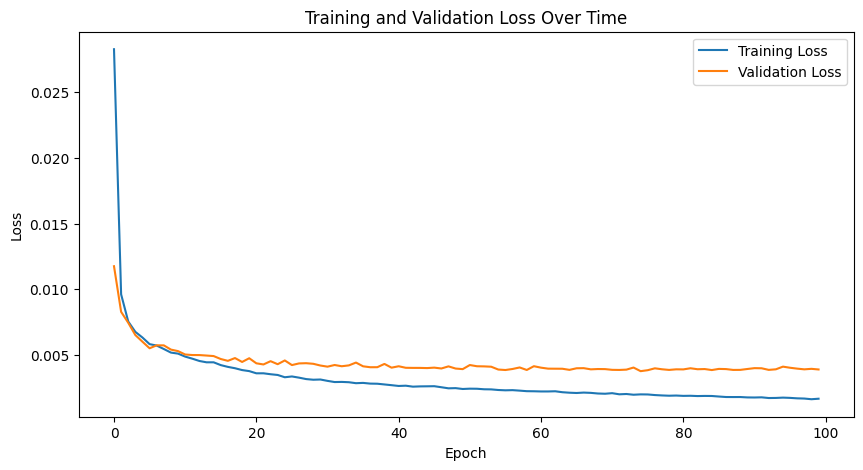




Test set: 
  Avg PSNR: 40.6 dB, Avg loss: 0.003534
  Min PSNR: 36.2 dB, Max PSNR: 43.3 dB



In [24]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [28]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_MAE_300_3c_lr3_b16.pth"
loss_fn = nn.L1Loss()
epochs = 300
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/300, loss: 0.3497
Epoch 1/300, loss: 0.0148
Epoch 1/300, loss: 0.0090
Validation loss: 0.0087

Epoch 2/300, loss: 0.0086
Epoch 2/300, loss: 0.0076
Epoch 2/300, loss: 0.0058
Validation loss: 0.0069

Epoch 3/300, loss: 0.0057
Epoch 3/300, loss: 0.0059
Epoch 3/300, loss: 0.0063
Validation loss: 0.0052

Epoch 4/300, loss: 0.0062
Epoch 4/300, loss: 0.0068
Epoch 4/300, loss: 0.0051
Validation loss: 0.0059

Epoch 5/300, loss: 0.0057
Epoch 5/300, loss: 0.0064
Epoch 5/300, loss: 0.0045
Validation loss: 0.0055

Epoch 6/300, loss: 0.0048
Epoch 6/300, loss: 0.0051
Epoch 6/300, loss: 0.0048
Validation loss: 0.0055

Epoch 7/300, loss: 0.0050
Epoch 7/300, loss: 0.0058
Epoch 7/300, loss: 0.0054
Validation loss: 0.0058

Epoch 8/300, loss: 0.0047
Epoch 8/300, loss: 0.0048
Epoch 8/300, loss: 0.0049
Validation loss: 0.0059

Epoch 9/300, loss: 0.0057
Epoch 9/300, loss: 0.0038
Epoch 9/300, loss: 0.0040
Validation loss: 0.0047

Epoch 10/300, loss: 0.0044
Epoch 10/300, loss: 0.0047
Epoch 10/300, loss:

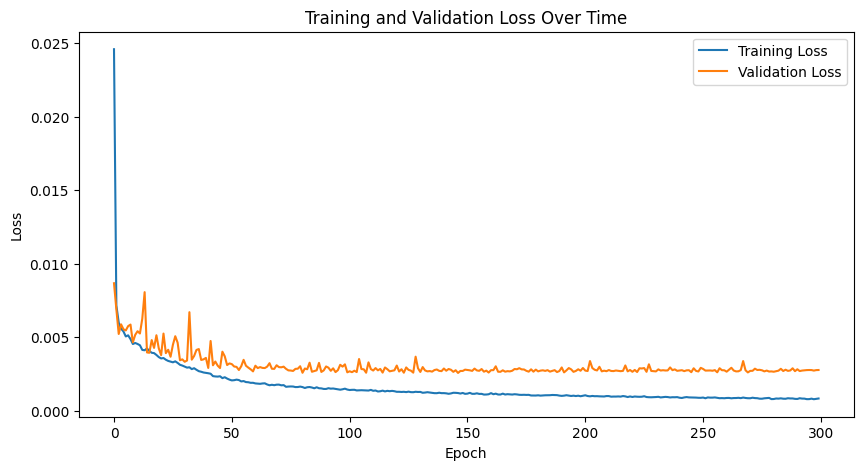




Test set: 
  Avg PSNR: 41.8 dB, Avg loss: 0.002694
  Min PSNR: 36.7 dB, Max PSNR: 44.3 dB



In [29]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [17]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_Adam_MAE_100_3c_lr3.pth"
loss_fn = nn.L1Loss()
epochs = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.3497
Epoch 1/100, loss: 0.0149
Validation loss: 0.0126

Epoch 2/100, loss: 0.0115
Epoch 2/100, loss: 0.0078
Validation loss: 0.0071

Epoch 3/100, loss: 0.0071
Epoch 3/100, loss: 0.0074
Validation loss: 0.0074

Epoch 4/100, loss: 0.0084
Epoch 4/100, loss: 0.0066
Validation loss: 0.0061

Epoch 5/100, loss: 0.0061
Epoch 5/100, loss: 0.0058
Validation loss: 0.0067

Epoch 6/100, loss: 0.0059
Epoch 6/100, loss: 0.0052
Validation loss: 0.0055

Epoch 7/100, loss: 0.0059
Epoch 7/100, loss: 0.0061
Validation loss: 0.0053

Epoch 8/100, loss: 0.0050
Epoch 8/100, loss: 0.0053
Validation loss: 0.0066

Epoch 9/100, loss: 0.0059
Epoch 9/100, loss: 0.0046
Validation loss: 0.0053

Epoch 10/100, loss: 0.0056
Epoch 10/100, loss: 0.0047
Validation loss: 0.0052

Epoch 11/100, loss: 0.0048
Epoch 11/100, loss: 0.0048
Validation loss: 0.0049

Epoch 12/100, loss: 0.0044
Epoch 12/100, loss: 0.0054
Validation loss: 0.0043

Epoch 13/100, loss: 0.0044
Epoch 13/100, loss: 0.0046
Validation loss:

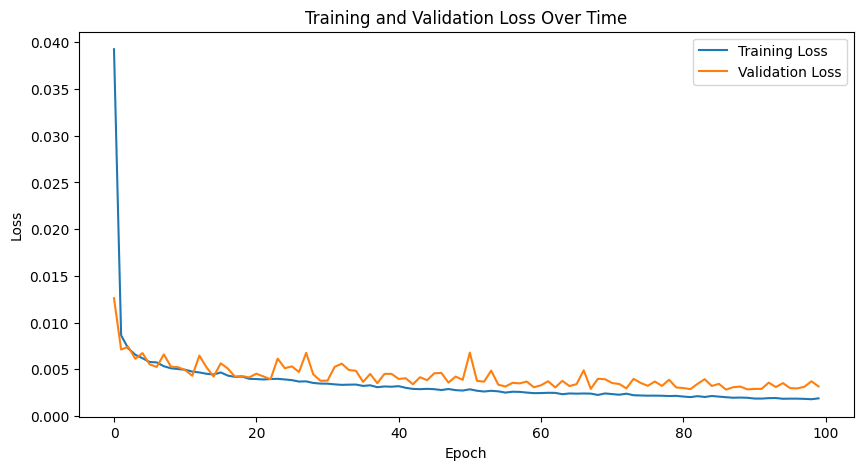




Test set: 
  Avg PSNR: 42.8 dB, Avg loss: 0.002855
  Min PSNR: 39.8 dB, Max PSNR: 44.0 dB



In [18]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [21]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_Adam_MAE_100_3c_lr3.pth"
loss_fn = nn.L1Loss()
epochs = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.3510
Validation loss: 0.0140

Epoch 2/100, loss: 0.0138
Validation loss: 0.0111

Epoch 3/100, loss: 0.0104
Validation loss: 0.0085

Epoch 4/100, loss: 0.0084
Validation loss: 0.0084

Epoch 5/100, loss: 0.0076
Validation loss: 0.0074

Epoch 6/100, loss: 0.0066
Validation loss: 0.0063

Epoch 7/100, loss: 0.0066
Validation loss: 0.0058

Epoch 8/100, loss: 0.0058
Validation loss: 0.0059

Epoch 9/100, loss: 0.0058
Validation loss: 0.0066

Epoch 10/100, loss: 0.0058
Validation loss: 0.0067

Epoch 11/100, loss: 0.0062
Validation loss: 0.0054

Epoch 12/100, loss: 0.0055
Validation loss: 0.0052

Epoch 13/100, loss: 0.0051
Validation loss: 0.0056

Epoch 14/100, loss: 0.0054
Validation loss: 0.0053

Epoch 15/100, loss: 0.0048
Validation loss: 0.0070

Epoch 16/100, loss: 0.0061
Validation loss: 0.0047

Epoch 17/100, loss: 0.0050
Validation loss: 0.0050

Epoch 18/100, loss: 0.0048
Validation loss: 0.0048

Epoch 19/100, loss: 0.0046
Validation loss: 0.0051

Epoch 20/100, loss: 0

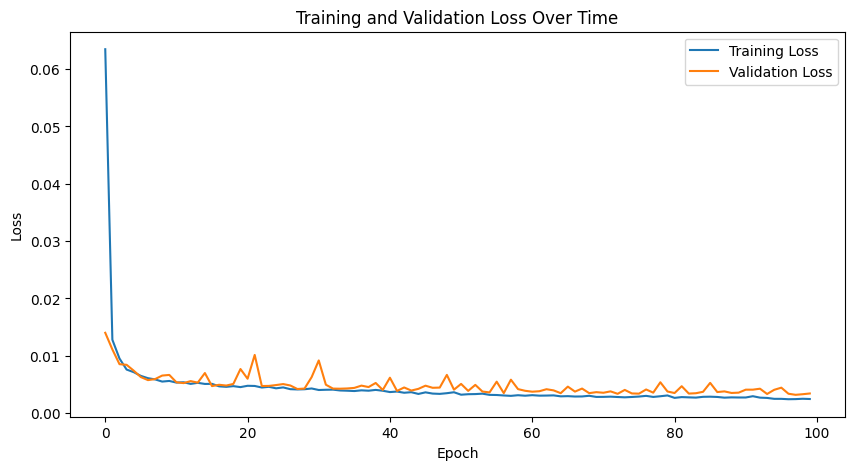




Test set: 
  Avg PSNR: 41.8 dB, Avg loss: 0.003059
  Min PSNR: 41.2 dB, Max PSNR: 42.3 dB



In [22]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [15]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_MAE_300_3c_lr3.pth"
loss_fn = nn.L1Loss()
epochs = 300
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/300, loss: 0.3510
Validation loss: 0.0141

Epoch 2/300, loss: 0.0139
Validation loss: 0.0139

Epoch 3/300, loss: 0.0110
Validation loss: 0.0082

Epoch 4/300, loss: 0.0080
Validation loss: 0.0068

Epoch 5/300, loss: 0.0066
Validation loss: 0.0064

Epoch 6/300, loss: 0.0062
Validation loss: 0.0065

Epoch 7/300, loss: 0.0063
Validation loss: 0.0062

Epoch 8/300, loss: 0.0060
Validation loss: 0.0067

Epoch 9/300, loss: 0.0062
Validation loss: 0.0062

Epoch 10/300, loss: 0.0057
Validation loss: 0.0053

Epoch 11/300, loss: 0.0052
Validation loss: 0.0060

Epoch 12/300, loss: 0.0052
Validation loss: 0.0056

Epoch 13/300, loss: 0.0055
Validation loss: 0.0053

Epoch 14/300, loss: 0.0051
Validation loss: 0.0052

Epoch 15/300, loss: 0.0052
Validation loss: 0.0049

Epoch 16/300, loss: 0.0047
Validation loss: 0.0058

Epoch 17/300, loss: 0.0048
Validation loss: 0.0050

Epoch 18/300, loss: 0.0050
Validation loss: 0.0058

Epoch 19/300, loss: 0.0053
Validation loss: 0.0047

Epoch 20/300, loss: 0

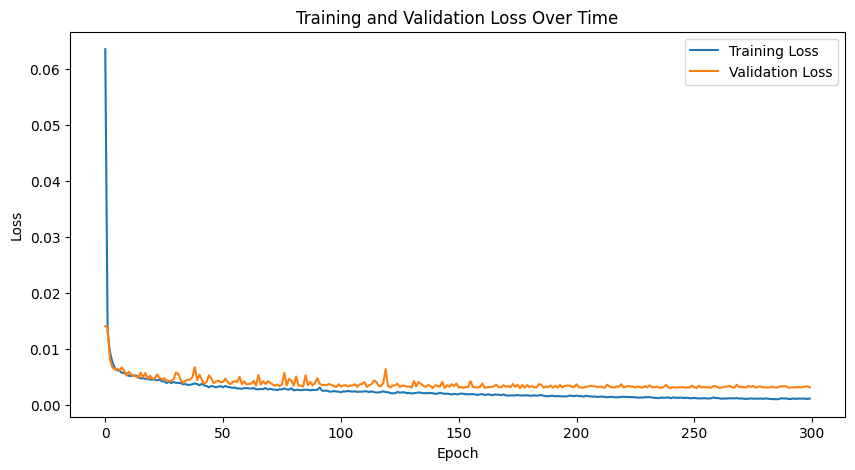




Test set: 
  Avg PSNR: 41.8 dB, Avg loss: 0.002986
  Min PSNR: 41.0 dB, Max PSNR: 42.9 dB



In [16]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

#### Prediction

In [ ]:
from src.predict import predict3
from src.visualization import visualize_prediction
from monai.networks.nets import UNet
import torch

# Définir le modèle UNet
device = "cpu"

low = "./test/low_edep.mhd"
ct = "./test/ct.mhd"
ground_truth_data = "./test/high_edep.mhd"
annotated = "./test/annotated_ct.npy"

paths = "./test/"
save_path = "./images/attention_Adam_MAE_100_3c_lr3.png"


model_path = './model/attention_Adam_MAE_100_3c_lr3.pth'

model = torch.load(model_path)



predicted_data = predict3(model, paths, device=device)

# Visualisation
visualize_prediction(low, ground_truth_data, predicted_data, save_path, ct, annotated)